## Summary of Yelp Star Prediction

### 1. Introduction
More than ever before, people’s decisions of what to eat or where to go are often influenced by other’s opinions. The internet has become the ultimate trove of the opinions of many people. Today, websites like Yelp have turned to a vast database for restaurants, and they include reviews and ratings written by customers. This crowdsourcing method of extracting satisfaction has succeeded in providing different sources of opinions about a certain restaurant.

This project mainly aims at **finding out what makes a review positive or negative** and **predicting the ratings of reviews based on the text and a small set of relevant attributes**.

From our research, we find that words with sentiment orientation play an important role in predicting star ratings. Moreover, it is easier to distinguish positive (3-5 stars) reviews from negative (1-2 star(s)) ones than telling the specific star rating.

### 2. Data Preparation
For our experiments, we used a subset of Yelp reviews, which includes about 1.5 million entries. These data provide useful information such as business profile, review text, date of review etc.

#### 2.1 Sampling
After some preliminary exploration , we find that there are a lot more positive reviews (4-5 stars) than negative (1-3 stars) reviews. To balance the class distribution as well as reducing the sample size, we randomly selected 100,000 reviews from each star rating for further analysis. Also, the businesses that do not have 3 reviews or exist less than 14 days are excluded.

#### 2.2 Data preprocessing
First, we cleaned the review texts by **removing punctuations, digits, extra whitespaces and transforming all letters to lower case**. After that, we performed **spelling correction** and **lemmatization**. 

Next, we would like to take context into consideration. It could be misleading if we only focus on a single word but ignore the context. For example, we may extract positive information from the sentence "I don't like it and I'm not happy." after tokenization. Meanwhile, it could convey totally opposite sentiments depends on different context, such as "pretty good" and "pretty bad", "go back" and "never go back". Thus, we took the following two steps to avoid any out-of-context interpretation.
* We change negation format to reserve the negative meaning before tokenizing. E.g. by changing ***don't like*** to ***not_like*** and treating it as a single word.
* We transform common phrases together into one single word. E.g. ***highly recommended*** to ***highly_recommended***, ***reasonable price*** to ***reasonable_price***.


### 3. Feature Engineering

There are 7 variables in the raw data set, such as business location, review date etc. However, after further exploration, we decide to use review text as the predictor solely, because other variables do not contribute significantly to the star ratings. In addition to that, in common sense the star rating of a review depends mostly on the review content. Thus our feature engineering part is based on review text only.

The raw text contains millions of unique words. However, not all of them are useful for the prediction of star ratings. We want to select the most useful words, and create representative features based on these selected words. The next two sections give a detailed explanation of the words selection and feature creation.

#### 3.1 Words Selection

The first question is "What are useful words?" Intuitively, *great* and *worst* are useful. The former tend to appear more frequently in higher star rating reviews, while the latter tend to appear more in lower ones. In contrast, *food* and *service* are useless words since they seem to appear with the same frequency in each star rating. More generally, useful words are those with a significantly higher likelihood of appearing in certain star rating level than other levels. Thus, they have high ability to distinguish between those different star ratings. 

The second question concerns about the coverage percentage of useful words. If only 10% of reviews contain those words, our analysis may not have generalized well. Thus, during the process of words selection, we also keep an eye on the coverage percentage. 

The following sections introduce two metrics that we use to evaluate how "useful" a word is and our selection result.

##### 3.1.1 Inverse Document Frequency (IDF)

The Inverse Document Frequency of a word measures how often it appears in a collection of reviews. The formula is as follows:

$$ \text{IDF}(\text{word}) = \frac{N}{n} ,$$ 

where $N$ is the total number of reviews, and $n$ is the number of reviews containing the specific word. The larger IDF is, the fewer reviews contain the specific word. For example, words like "food", "menu", "chicken" and "restaurant" have lower IDF. Words like "thump", "cray" and "coho" have higher IDF.

##### 3.1.2 Diversity

The diversity of a word measures its ability to distinguish between different star ratings. It is the unevenness of frequency among different star ratings. If a word has frequency $f=(f_1,f_2,f_3,f_4,f_5)$  star 1 to star 5 respectively, then the diversity of this word will be:
$$Div=\frac{\sqrt{\sum_{i=1}^5 (f_i-\bar{f})^2}}{\bar{f}}$$

##### 3.1.3 Words Selection Result

After we get two metrics in 3.1.1 and 3.1.2, we can draw the following plot. Each point represents a unique word. 
By synthesizing the two questions mentioned above, we come up with a threshold indicated by two blue lines that split the figure into 4 parts. 

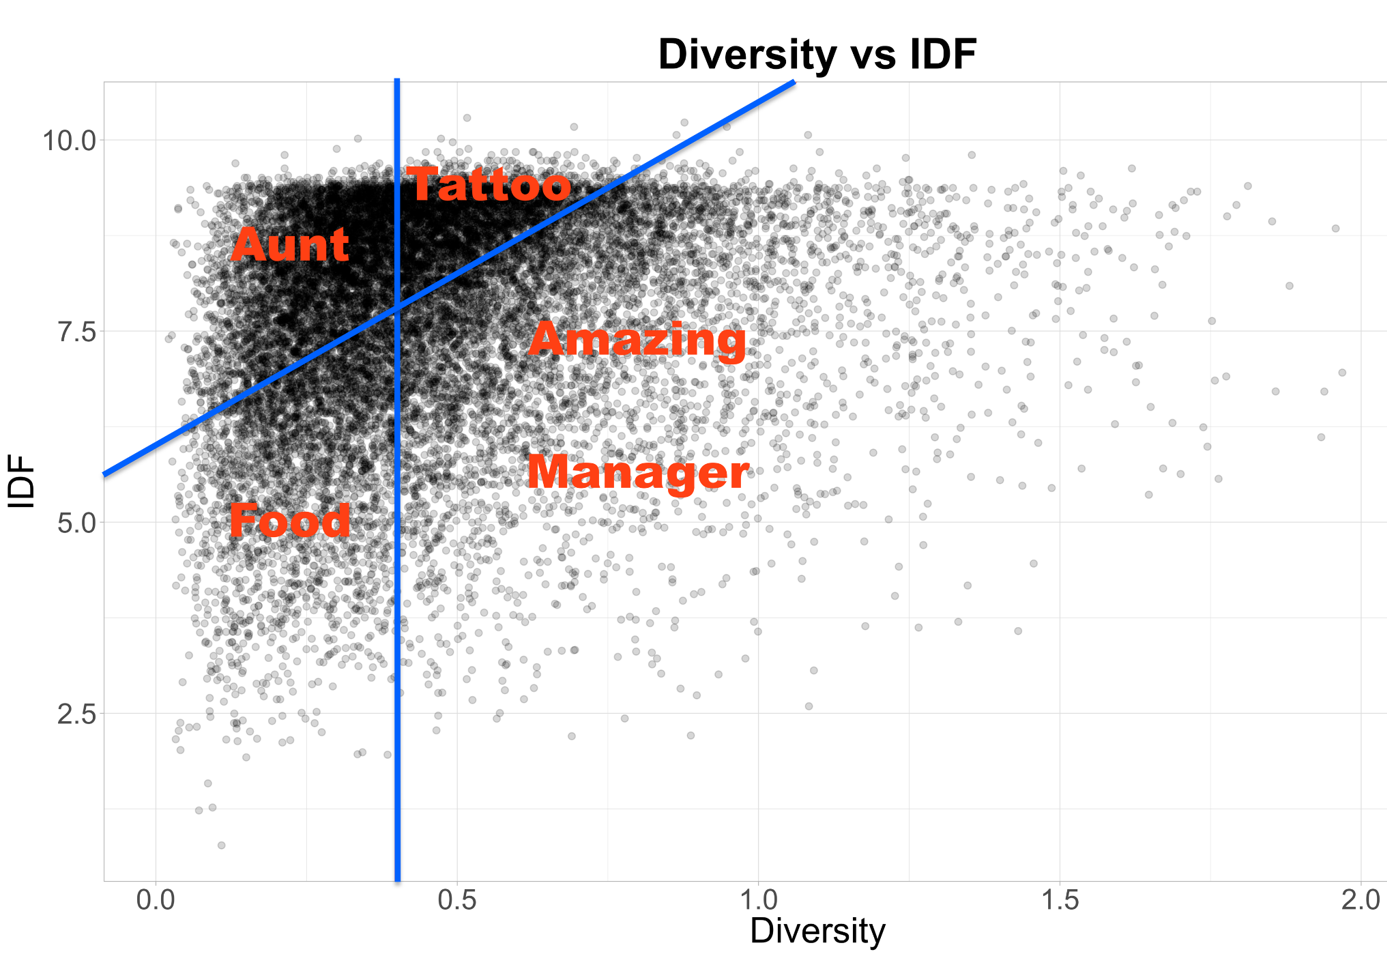

In [11]:
Image("image/diversity_idf.png",width=500,height=300)

We believe that words in the bottom right part have higher ability to distinguish different star ratings, and they appear in most reviews. This part contains 5814 unique words, which cover 99.2% reviews.


#### 3.2 Fearture Creation

##### 3.2.1 Word Score

To measure the polarity of a word, we introduce the ***word score***. Word score is the average star (after mean-subtraction and standardization) of all the reviews containing this word.

The left image presents the histogram of all the words in our train set. As we can see, most of the words are concentrated around 0. This means that they do not provide much information in interpreting review stars. However, after selecting the 5814 words mentioned before, we see an obvious bimodal distribution. All the words are clearly divided into "negative" and "positive" parts. The plots prove that the words selection procedure are effective in filtering out useless words.

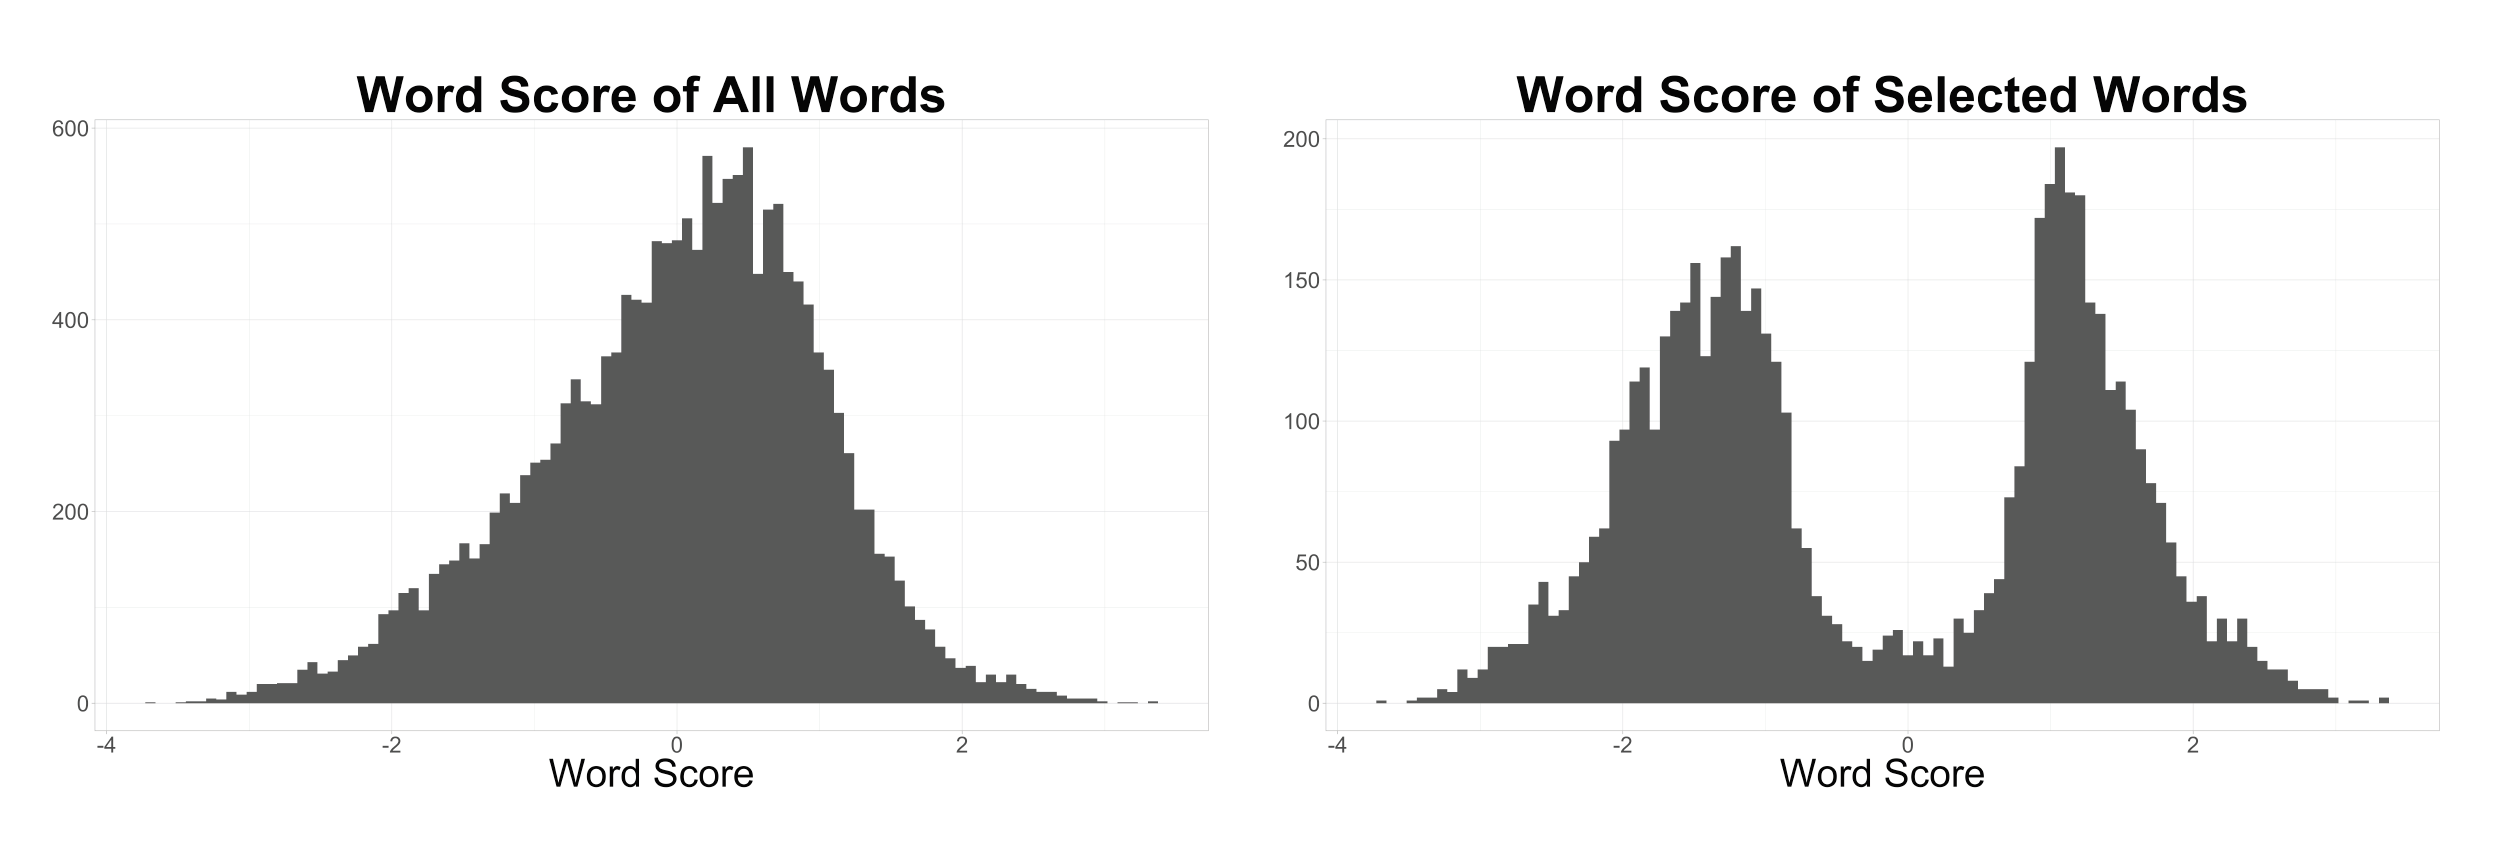

In [23]:
Image("image/histograms.png",width=700,height=400)

##### 3.2.2 Extracted Features

**Minimum, Average and Maximum Scores**

Now that we have a score for each word, we are able to convert a review into an ordered score vector **Y**. The minimum value, mean value and maximum value can be extracted from **Y**.
* All the three plots have an increasing trend.
* Compared to the other two scores, the average score most effectively distinguish the star ratings.
* The minimum score could not distinguish between the 4-star and 5-star ratings, but it has the ability to distinguish the different ratings in negative reviews.
* Likewise, the maximum score has the ability to distinguish the star ratings, especially between the 3- and 4-star ratings.

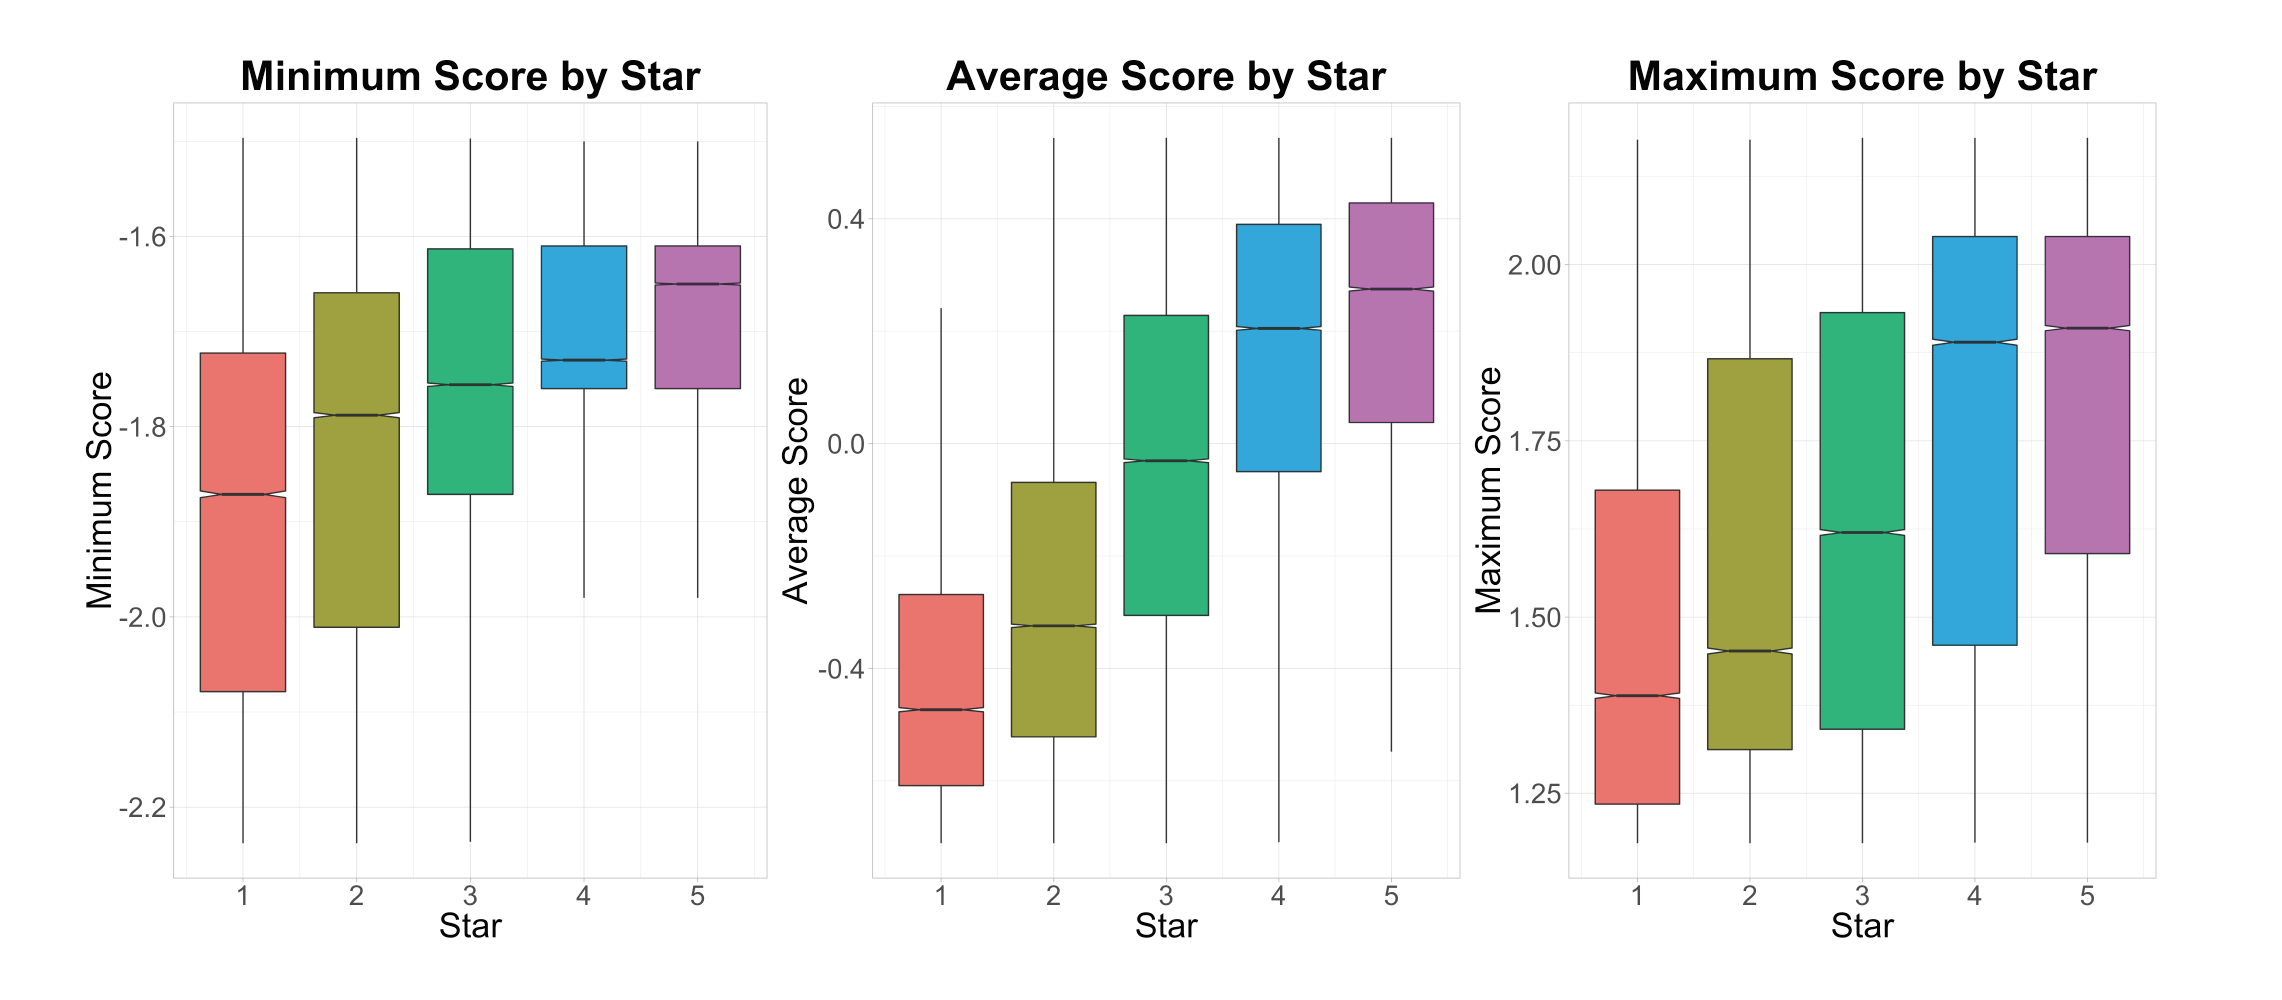

In [13]:
Image("image/scores.png",width=700,height=400)

**Emotion Trend**

The three features above do not take the order information into account. Consider the two reviews below:

1) One star off because the **service is miss** but their curry makes up for everything else. Seriously **the best curry** in town.

2) Ambience was **awesome** but service was **so terrible**. We didn’t even get a chance to try anything except for our first round of drinks.

Both of the reviews contain some positive and some negative comments. However, the first is a 4-star review, while the second review was only given 2 stars. It seems that people are okay with giving negative comments at the beginning, followed by positive comments. However, if negative comments are followed by positive comments, they may express a lower satisfaction towards the restaurant. 

In order to deal with this case, we introduce a new feature: ***emotion trend***. We have previously obtained the score vector **Y**. Now, we denote the index vector as **X**. The emotion trend is then calculated as the slope, $\beta$, of the regression line of **Y** vs **X**. We move on taking a power transformation $\tilde\beta=sign(\beta)\sqrt{|\beta|}$.

There is an increasing trend of slope as star rating goes up. Furthermore, there is a relatively large gap between star 2 and star 3 ratings. This phenomenon shows that emotion trend has the ability to distinguish star ratings, especially when a review seems to be neutral.

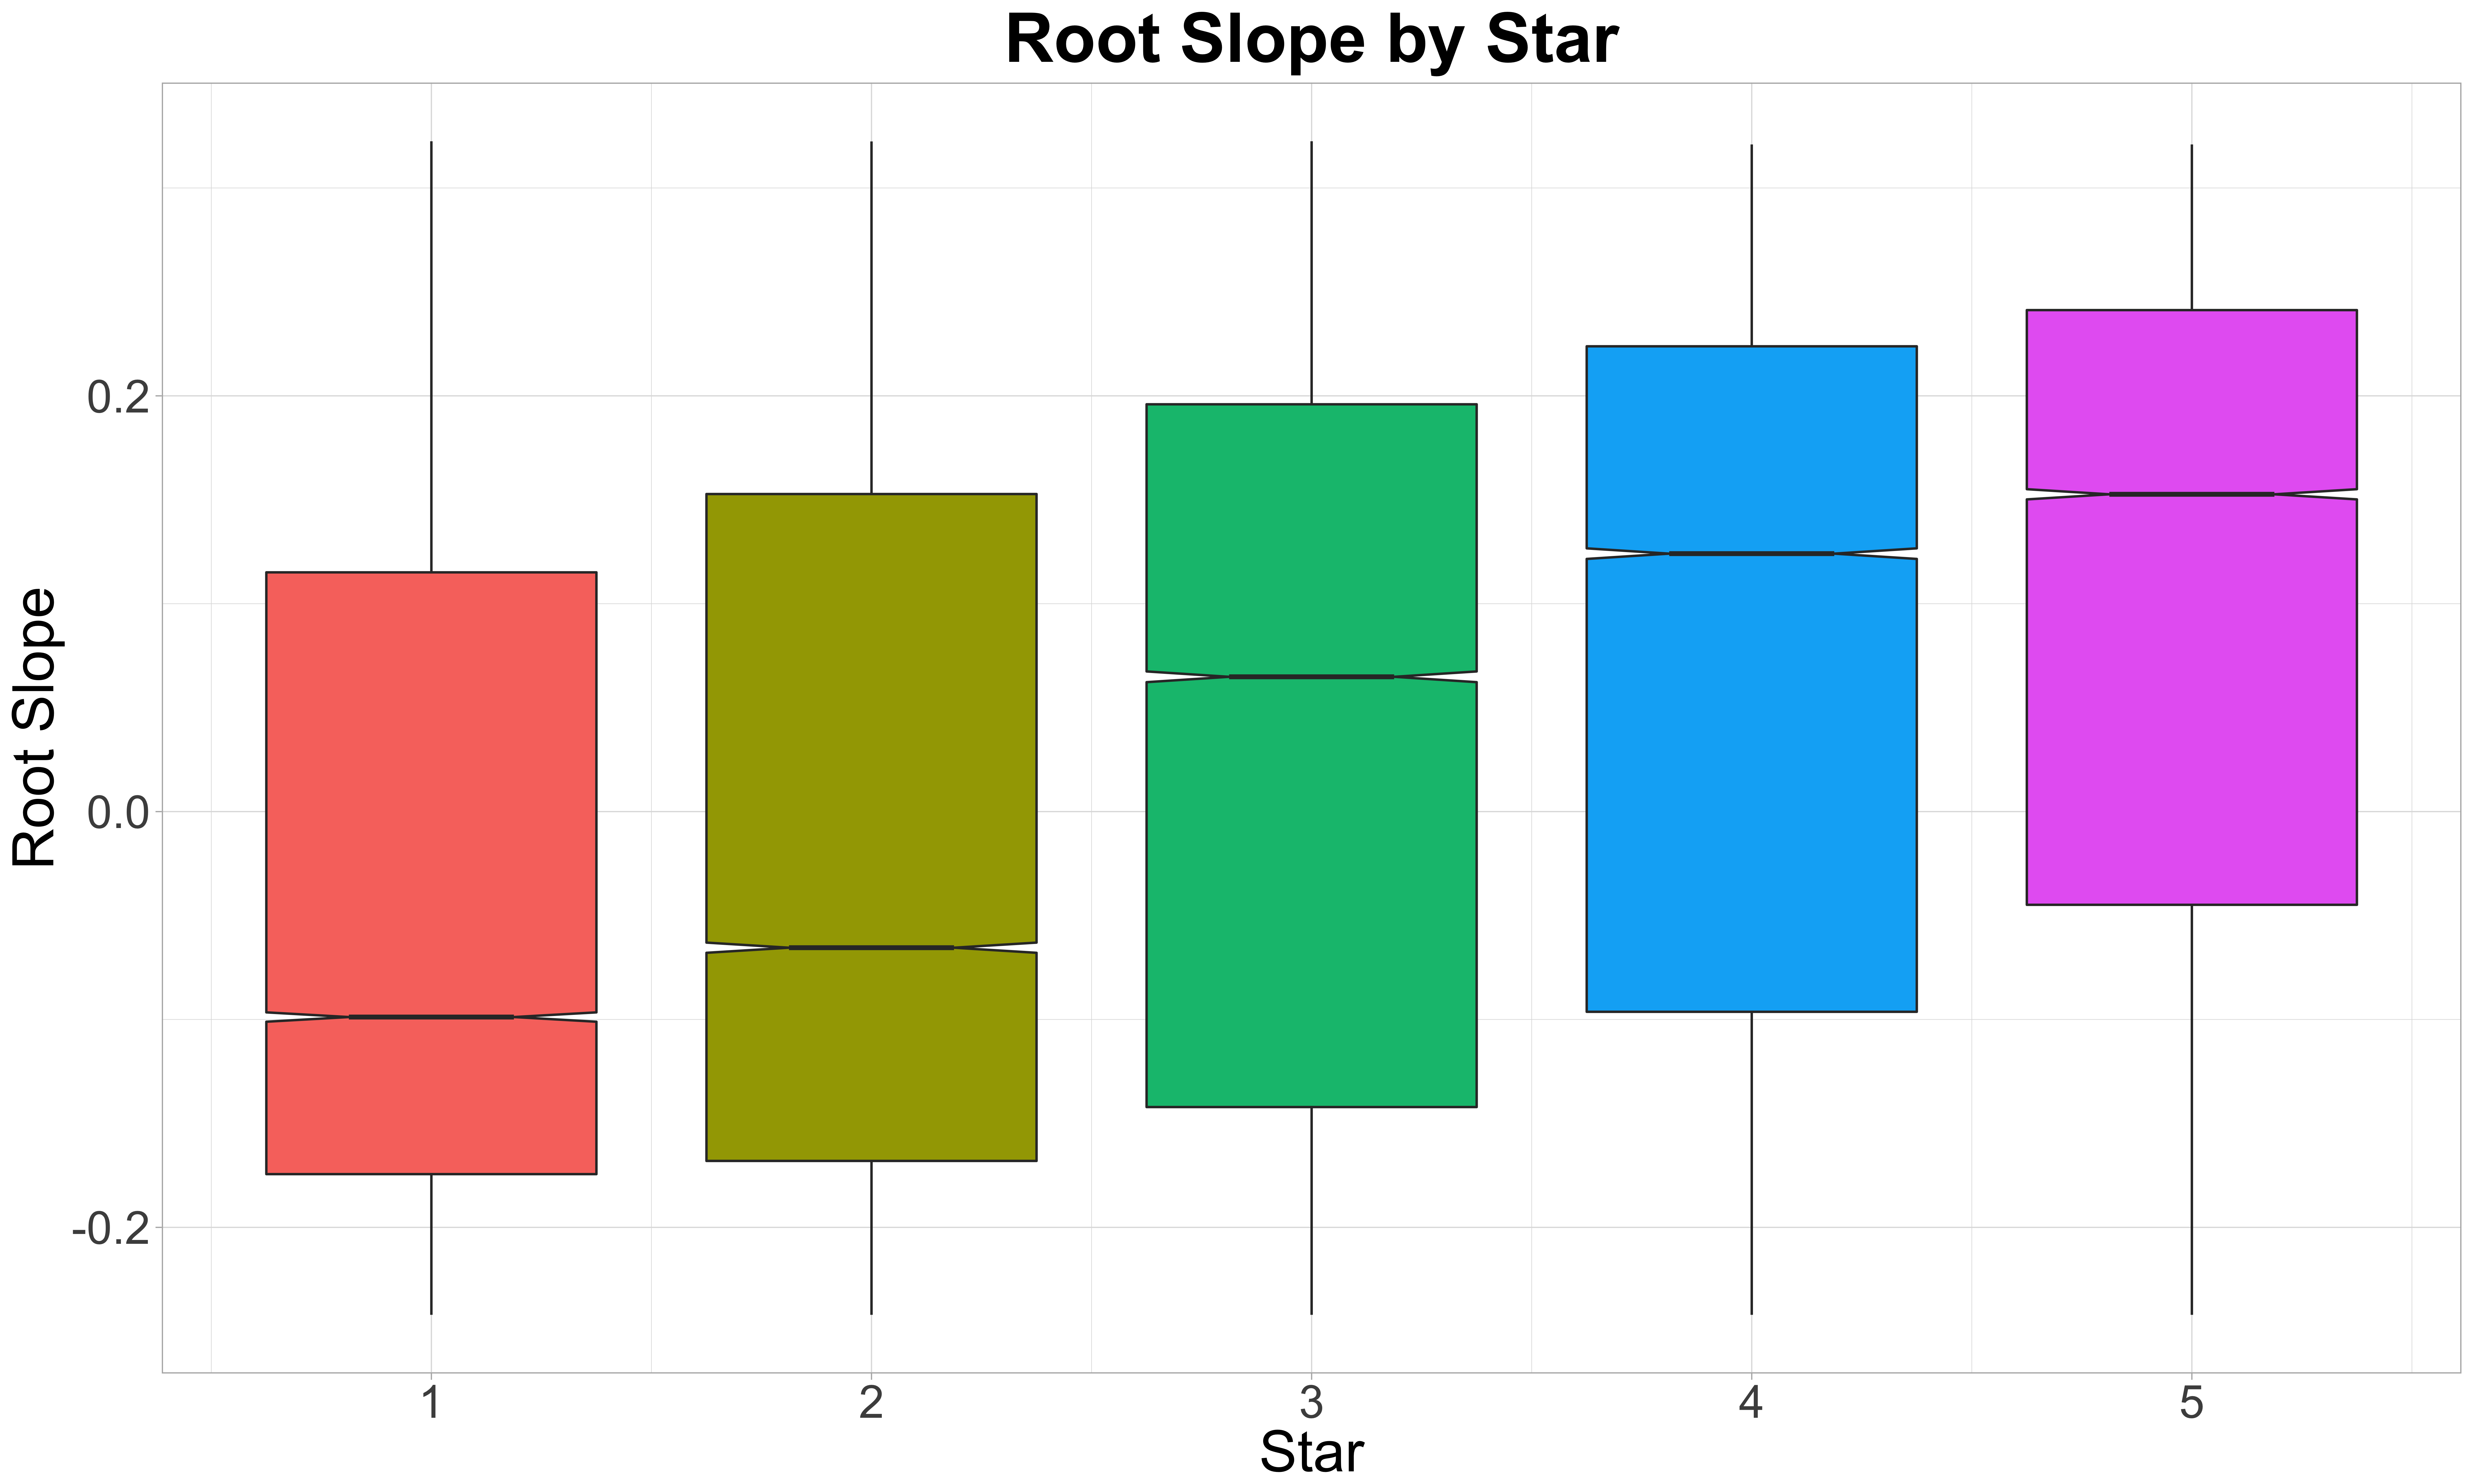

In [10]:
Image("image/root_slope.png",width=400,height=300)

### 4. Modeling

#### 4.1 Model by extracted features
Now, we have four extracted features for model building. We find that minimum score, average score and maximum score have cubed relationship with star ratings. Hence, we add the value of second and third order power of them.

To get an interpretable model, we choose classification and regression tree model for this part. The fitted model can be represented as the figure below. For example, if a review has average score less than -0.1, squared  average score greater than 1.1 and squared minimum score greater than 5.8, then the fitted star rating is 1.2.

Every node in the tree uses the feature that could split the reviews in a way that star ratings of the two groups are farthest apart. For example, the average score can best distinguish different star ratings at the first node, which split the reviews into positive and negative groups. In both groups, average score continues to play a role in the second node. Then, the maximum score begins to work, measuring how positive a review is. Meanwhile, the minimum score measures how negative a review is. On the other hand, the slope begins to work when a review seems to be neutral based on other three features.

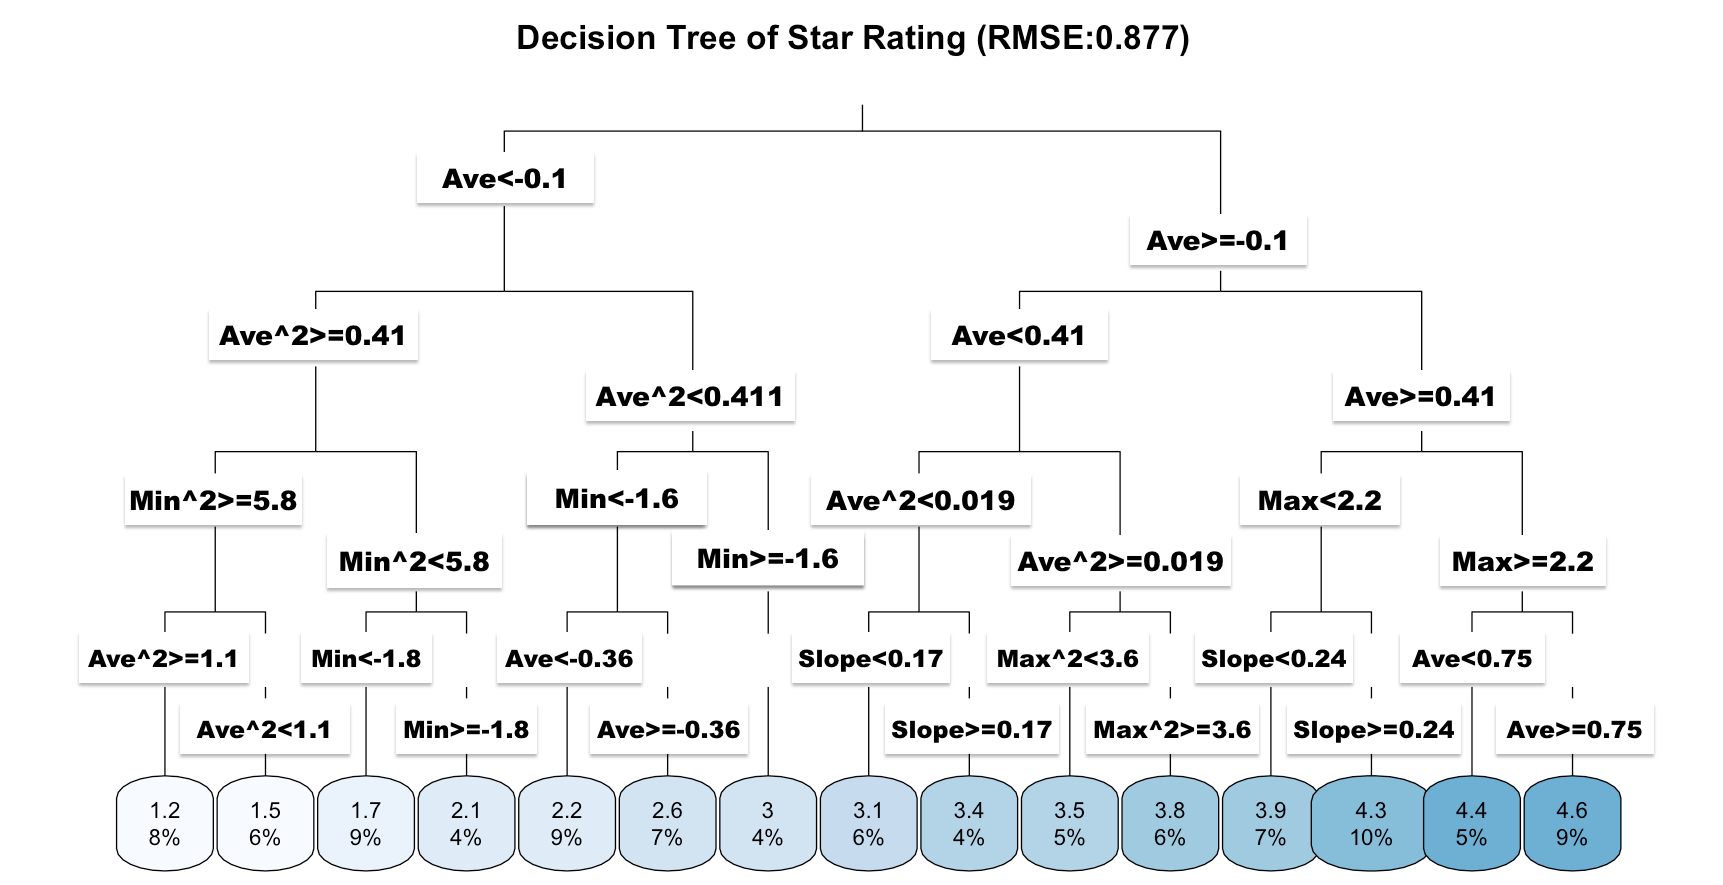

In [5]:
Image("image/tree.png",width=800,height=400)

#### 4.2 Bag of Words Model

In order to predict the star ratings more accurately, we tried some machine learning methods using sparse matrix, where the i-th row represents the i-th review, and the j-th column represents the j-th token. The (i,j)-entry of this matrix represents the tf-idf quantity of the j-th token in the i-th review.

After several tries, we find it more accurate to consider both one single word and two pairwise words in the model fitting. For example: **I like it** is transformed into **i**, **like**, **it**, **i like** and **like it**.

Our initial idea is to build a one-step model directly using Support Vector Classifier, Linear Regression and Naive Bayes. Going on from there, we dig a little deeper by dividing the star ratings into positive ratings (3-5 stars) and negative ratings (1-2 star(s)). Then, we build two separate models.

Support Vector Classifier is a useful way in the binary classification of negative and positive reviews, and it achieves an accuracy around 90%. Here, we compare several models:

|       | Model | RMSE |
| ------| ------ | ------ |
| 1-step model | SVC | 0.75 |
| 1-step model | NB | 0.84 |
| 2-step model | SVC+SVC | 0.716 |
| 2-step model | **SVC+Linear** | **0.665** |

### 5. Conclusion

#### 5.1 Thesis Statement
* Words with sentiment orientation play a key role in predicting star ratings.
* It is easier to distinguish between positive (3-5 stars) and negative (1-2 star(s)) reviews than telling a specific star rating.

#### 5.2 Strengths and Weaknesses

In this section, we analyze our strengths and weaknesses during the whole analysis procedure.

**Pros: ** 
* Take context into consideration       
* The features are easy to interpret
* Gain more insight of how review text contributes to its star rating
* The prediction of test data are well-performed
* Time efficiency: about 10 min per running round
              
**Cons: ** 
* May lose information due to the limited sample size
* The decision tree model is not accurate, and the higher order interaction is not taken into consideration
* Violate some model assumptions

### Division of work
* Guanxu Su: Data Preprocessing; Text Cleaning; Feature Extraction
* Shurong Gu: Model Building; Final Kaggle Prediction
* Yuwei Sun: Parameter Optimization; Presentation Organization